### build RNN from scratch

Author: [Chuong Hoa Loc](https://github.com/Locchuong96)
[email](locchuong123@gmail.com)

model many-to-one architecture

![rnn_architecture](rnn_architecture.png)

Use the previous values as input to predict the next value (*Example*: y_51th use 50 previous values of y to predict, y_52th use from value 51th to 1st to predict), when you add input each timestep, only the element corresponding this timestep contribute value, the others get value zero, there are some hyperparameter you must to clarify

|**Hyperparameter**|**Usage**|**Default**|
|---|---|---|
|`T` or `seg_len`| the number of previous steps use to predict next value, also know as sequence lenght |(default:50) |
|bptt_truncate| the number of previous timestep you use to calculate backpropagation through time, you can count every timestep before the current timstep or you can use somes previous step *(this also know as **truncated backpropagation through time -bptt**)* |(default:3)|
|learning_rate|the learing rate for gradient descent update|(default:1e-4)|
|epochs|how many time you want to train your data with|(default:10)|
|hidden_dim|number of nodes in hidden layer|(default:100)|
|output_dim|number of output|(default:1)|
|min_clip_val|minimum value accepted in the matrix when calculate differentials|(default:-10)|
|max_clip_val|maximum value accepted in the matrix when calculate differentials|(default:10)|

#### repair the dataset

In [41]:
# import the required packages
import time 
import math 
import numpy as np 
import matplotlib.pyplot as plt

In [42]:
# hyperparameters
learning_rate =  1e-4
T = 50 # sequence length
epochs = 10
hidden_dim = 100
output_dim = 1
bptt_truncate = 3
min_clip_val = -10
max_clip_val = 10

In [43]:
# activation function
def sigmoid(x):
    return 1/(1+np.exp(-x))

def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def softmax(x):
    xt = np.exp(x - np.max(x))
    return xt / np.sum(xt)

sin_wave (200,)


Text(0.5, 1.0, 'full dataset')

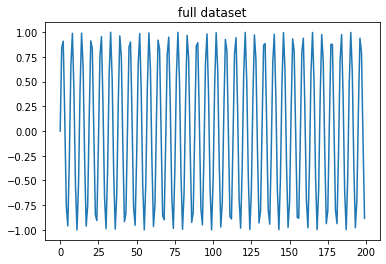

In [44]:
# repair dataset
sin_wave = np.array([math.sin(x) for x in range(200)])
print(f'sin_wave {sin_wave.shape}')
plt.plot(sin_wave)
plt.title('full dataset')

X (100, 50, 1)
Y (100, 1)


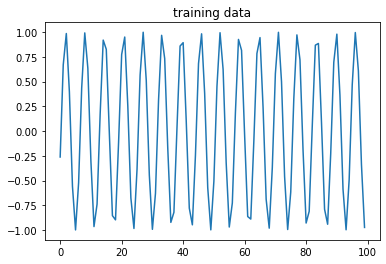

In [45]:
# training data
X = [] 
Y = []
num_records = len(sin_wave) - T # the first 150 element will be take for training data, the next 50 element will be for validation

# X entries are 50 data points
# Y entries are the 51 data points
for i in range(num_records - T):
    X.append(sin_wave[i:i+T])
    Y.append(sin_wave[i+T])

plt.plot(Y)
plt.title('training data')

# convert to numpy array
X = np.array(X)
Y = np.array(Y)

# reshape
X = np.expand_dims(X,2)
print(f'X {X.shape}')
Y = np.expand_dims(Y,1)
print(f'Y {Y.shape}')

X_val (50, 50, 1)
Y_val (50, 1)


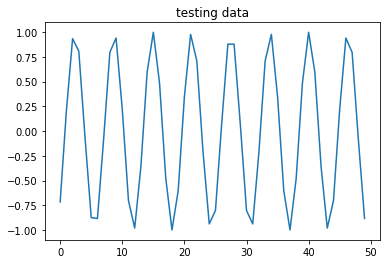

In [46]:
# training data
X_val = [] 
Y_val = []

for i in range(num_records-T,num_records):
    X_val.append(sin_wave[i:i+T])
    Y_val.append(sin_wave[i+T])

plt.plot(Y_val)
plt.title('testing data')

# convert to numpy array
X_val = np.array(X_val)
Y_val = np.array(Y_val)

# reshape
X_val = np.expand_dims(X_val,2)
print(f'X_val {X_val.shape}')
Y_val = np.expand_dims(Y_val,1)
print(f'Y_val {Y_val.shape}')

X (100, 50, 1)
Y (100, 1)
X_val (50, 50, 1)
Y_val (50, 1)


Text(0.5, 1.0, 'full dataset')

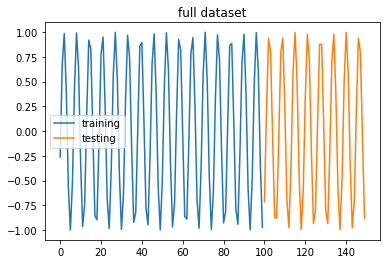

In [47]:
# plot training and validation dataset
print(f'X {X.shape}')
print(f'Y {Y.shape}')
print(f'X_val {X_val.shape}')
print(f'Y_val {Y_val.shape}')
plt.plot(range(len(X)),Y,label = 'training')
plt.plot(range(len(X),len(X)+ len(X_val)),Y_val,label = 'testing')
plt.legend(loc = 'best')
plt.title('full dataset')

####  Huiming Song implementation without bias

- `U` is the weight matrix for weights between input and hidden layers

- `V` is the weight matrix for weights between hidden and ouput layers

- `W` is the weight matrix for shared weights in the RNN layer (hidden layer)

|****|**shape**|**default**|
|---|---|---|
|`U`|*(hidden_dim,T)*|*(100,50)*|
|`W`|*(hidden_dim,hidden_dim)*|*(100,100)*|
|`V`|*(output_dim,hidden_dim)*|*(1,100)*|
|`X`|*(no_of_element,hidden_dim,1)*|*(100,50,1)*|
|`Y`|*(no_of_element,output_dim)*|*(100,1)*|
|`X_val`|*(no_of_element,hidden_dim,1)*|*(100,50,1)*|
|`Y_val`|*(no_of_element,output_dim)*|*(100,1)*|

$$ $$

In [8]:
# initialize matrix
def initialize_matrices(T,hidden_dim,output_dim):
    np.random.seed(3454)
    U = np.random.uniform(0,1,(hidden_dim,T)) # weights between input layer and hidden layer
    V = np.random.uniform(0,1,(output_dim,hidden_dim)) # weights between hidden layer and output layer
    W = np.random.uniform(0,1,(hidden_dim,hidden_dim)) # recurrent weights between each timestep layer (RNN weights)
    return U,W,V

U,W,V = initialize_matrices(T,hidden_dim,output_dim)

print(f'U {U.shape}')
print(f'V {V.shape}')
print(f'W {W.shape}')

U (100, 50)
V (1, 100)
W (100, 100)


**Forward propagation**

Generally

$$ z_{t} = U \otimes x_{t} + W \otimes h_{t} + b_{h} $$

$$ h_{t} = tanh(z_{t})$$

$$ y_{t} = o_{t} = V \otimes z_{t} + b_{y} $$

$ timestep = 1 $

$$ z_{1} = U \otimes x_{1} + W \otimes h_{1} + b_{h} $$

$$ h_{1} = tanh(z_{1}) $$

$$ y_{1} = o_{1} = V \otimes z_{1} + b_{y} $$

$ timestep = 2 $

$$ z_{2} = U \otimes x_{2} + W \otimes h_{2} + b_{h} $$

$$ h_{2} = tanh(z_{2}) $$

$$ y_{2} = o_{2} = V \otimes z_{2} + b_{y} $$

$$ ... $$

$ timestep = t $

$$ z_{t} = U \otimes x_{t} + W \otimes h_{t} + b_{h} $$

$$ h_{t} = tanh(z_{t}) $$

$$ y_{t} = o_{t} = V \otimes z_{t} + b_{y} $$

You can use *softmax* or *sigmoid* activation for y

In [9]:
# forward function
x,y = X[0],Y[0]

def forward_pass(x,y,U,V,W):
    layers = []
    prev_h = np.zeros((hidden_dim,1))
    for t in range(T):
        new_input = np.zeros(x.shape) # (T,1)
        new_input[t] = x[t]
        z = U @ x + W @ prev_h
        h = tanh(z) # (hidden_dim,T)x(T,1) + (hidden_dim,hidden_dim)x(hidden_dim,1)
        y_hat = o = V @ h # (1,hidden_dim)x(hidden_dim,1)
        layers.append({"prev_h":prev_h,"h":h})
        prev_h = h
    return layers,y_hat

layers,y_hat = forward_pass(x,y,U,V,W)

**Loss function**

this demo use *mean square error* to calculate how wrong between your prediction and the ground-truth

$$ L = \sum_{k}^{m}L_{k} = \frac{1}{2m} * \sum_{k}^{m} (y_{k} - \hat{y}_{k})^{2}$$

$$ \frac{\partial{L_{k}}}{\partial{\hat{y}}} = (y_{k} - \hat{y}_{k})$$

In [10]:
# calculate the loss
def calc_loss(X,Y,U,V,W):
    loss = 0.0
    for i in range(Y.shape[0]):
        x,y = X[i],Y[i]
        _,y_hat = forward_pass(x,y,U,V,W)
        loss += (y - y_hat)**2/2 #mean square error
    return np.float(loss)

loss = calc_loss(X,Y,U,V,W)
loss_val = calc_loss(X,Y,U,V,W)
print(f'Loss: {loss}, Validation Loss: {loss_val}')

Loss: 123018.72740117362, Validation Loss: 123018.72740117362


### backpropagation though time

We loop over each sample, do the forward pass and backward pass (backpropagation though time) and update matrix `V`,`U`,`W` by gradient descent, let call:

$$\frac{\partial{L}}{\partial{V}} = \frac{\partial{L_{k}}}{\partial{V}}$$

$$\frac{\partial{L}}{\partial{U}} = \frac{\partial{L_{k}}}{\partial{U}}$$

$$\frac{\partial{L}}{\partial{W}} = \frac{\partial{L_{k}}}{\partial{W}}$$

**gradient descent**

$$ V = V - lr * \frac{\partial{L}}{\partial{V}} $$

$$ U = U - lr * \frac{\partial{L}}{\partial{U}} $$

$$ W = W - lr * \frac{\partial{L}}{\partial{W}} $$

**differentials each sample**

$$\frac{\partial{L}}{\partial{V}} = \sum_{t}^{T}\frac{\partial{L_{t}}}{\partial{V}}$$

$$\frac{\partial{L}}{\partial{U}} = \sum_{t}^{T}\frac{\partial{L_{t}}}{\partial{U}}$$

$$\frac{\partial{L}}{\partial{W}} = \sum_{t}^{T}\frac{\partial{L_{t}}}{\partial{W}}$$

**differentials each timesteps**

You can take some differentials at previous timestep to calculate the differential at current timestep (*Also know as truncated-backpropagation-though-time*) or you can take all previous step (*backpropagation-though-time*). `U` and `W` are not simple as `V`, for example $\frac{\partial{L_{i}}}{\partial{U}}$ is a implicit differential, because at $h_{i} = tanh(Ux_{i} + Vh_{i-1})$ and $h_{i-1} = tanh(Ux_{i-1} + Vh_{i-2})$, there is have variable `U` inside $h_{i-1}$

$$\frac{\partial{L_{t}}}{\partial{V}} =\frac{\partial{L_{t}}}{\partial{V}}$$

$$\frac{\partial{L_{t}}}{\partial{U}} = \sum_{i}^{t}\frac{\partial{L_{i}}}{\partial{U}}$$

$$\frac{\partial{L_{t}}}{\partial{W}} = \sum_{i}^{t}\frac{\partial{L_{i}}}{\partial{W}}$$

**how to calculate the implicit differential**

This calculation base on [Song Huiming](https://songhuiming.github.io/pages/2017/08/20/build-recurrent-neural-network-from-scratch/)

![bptt2](bptt2.png)

$$\frac{\partial{h_{i}}}{\partial{U}} = \frac{\partial{h_{i}}}{\partial{U}}+\frac{\partial{h_{i}}}{\partial{h_{i-1}}} * \frac{\partial{h_{i-1}}}{\partial{U}}$$

**Let calculate partial derivative of $\frac{\partial{L_{3}}}{\partial{U}}$ and $\frac{\partial{L_{3}}}{\partial{W}}$**

$$\frac{\partial{L_{3}}}{\partial{U}} = \frac{\partial{L_{3}}}{\partial{\hat{y}}} \frac{\partial{\hat{y}}}{\partial{h_{3}}} \frac{\partial{h_{3}}}{\partial{U}}$$

**note**: Actually $$\frac{\partial{h_{3}}}{\partial{U}} = \frac{\partial{h_{3}}}{\partial{z_{3}}} \frac{\partial{z_{3}}}{\partial{U}}$$ as $$\frac{\partial{h_{k}}}{\partial{U}} = \frac{\partial{h_{k}}}{\partial{z_{k}}} \frac{\partial{z_{k}}}{\partial{U}}$$ 

$$\frac{\partial{L_{3}}}{\partial{W}} = \frac{\partial{L_{3}}}{\partial{\hat{y}}} \frac{\partial{\hat{y}}}{\partial{h_{3}}} \frac{\partial{h_{3}}}{\partial{W}}$$ 
but we simplify in writing, with activation function *tanh* $\frac{\partial{h_{3}}}{\partial{z_{3}}} = (1 - h_{3}^{2})$ or with activation function *sigmoid* $\frac{\partial{h_{3}}}{\partial{z_{3}}} = h_{3}(1 - h_{3})$ with

$$\frac{\partial{L_{3}}}{\partial{\hat{y}}} = (\hat{y_{3}} - y_{3})$$

$$\frac{\partial{\hat{y}}}{\partial{h_{3}}} = V$$

$$\frac{\partial{h_{3}}}{\partial{U}} = \frac{\partial{h_{3}}}{\partial{U}}+\frac{\partial{h_{3}}}{\partial{h_{2}}} * \frac{\partial{h_{2}}}{\partial{U}}$$

How we can calculate $\frac{\partial{h_{3}}}{\partial{U}}$? let denote this:

$$d_{3} \overset{\Delta}{=} (\hat{y_{3}} - y_{3})V(1-h_{3}^{2})$$

$$d_{2} \overset{\Delta}{=} d_{3}W(1-h_{2}^{2})$$

$$d_{1} \overset{\Delta}{=} d_{2}W(1-h_{1}^{2})$$

let calculate all the hidden unit status to the parameter `U`

$$ \frac{\partial{h_{1}}}{\partial{U}} = \frac{\partial{h_{1}}}{\partial{z_{1}}} \frac{\partial{z_{1}}}{\partial{U}} = (1 - h_{1}^{2})(\frac{\partial{z_{1}}}{\partial{U}}+\frac{\partial{z_{1}}}{\partial{z_{0}}} * \frac{\partial{z_{0}}}{\partial{U}})  = (1 - h_{1}^{2})(x_{1} + \frac{\partial{z_{0}}}{\partial{U}})=(1 - h_{1}^{2})x_{1}$$

$$ \frac{\partial{h_{2}}}{\partial{U}} = \frac{\partial{h_{2}}}{\partial{z_{2}}} \frac{\partial{z_{2}}}{\partial{U}} = (1 - h_{2}^{2})(\frac{\partial{z_{2}}}{\partial{U}}+\frac{\partial{z_{2}}}{\partial{h_{1}}} * \frac{\partial{h_{1}}}{\partial{U}})  = (1 - h_{2}^{2})(x_{2} + W\frac{\partial{h_{1}}}{\partial{U}}) = (1 - h_{2}^{2})(x_{2} + W (1 - h_{1}^{2})x_{1})$$

$$ \frac{\partial{h_{3}}}{\partial{U}} = (1 - h_{3}^{2})(x_{3} + W\frac{\partial{h_{2}}}{\partial{U}}) = (1 - h_{3}^{2})(x_{3} + W (1 - h_{2}^{2})(x_{2} + W (1 - h_{1}^{2})x_{1}))$$

After we get this, we can calculate the partial derivative of error $\frac{\partial{h_{3}}}{\partial{U}}$

$$ \frac{\partial{L_{3}}}{\partial{U}} = \frac{\partial{L_{3}}}{\partial{\hat{y}}} \frac{\partial{\hat{y}}}{\partial{h_{3}}} \frac{\partial{h_{3}}}{\partial{U}} = (\hat{y_{3}} - y_{3}) V (1 - h_{3}^{2})(x_{3} + W (1 - h_{2}^{2})(x_{2} + W (1 - h_{1}^{2})x_{1})) $$ 

$$ \frac{\partial{L_{3}}}{\partial{U}} = (\hat{y_{3}} - y_{3}) V (1 - h_{3}^{2})(x_{3} + W (1 - h_{2}^{2})(x_{2} + W (1 - h_{1}^{2})x_{1})) $$

$$ \frac{\partial{L_{3}}}{\partial{U}} \overset{\Delta}{=} d_{3}(x_{3} + W (1 - h_{2}^{2})(x_{2} + W (1 - h_{1}^{2})x_{1})) $$

$$ \frac{\partial{L_{3}}}{\partial{U}} = d_{3}x_{3} + d_{3} W (1 - h_{2}^{2})(x_{2} + W (1 - h_{1}^{2})x_{1})) $$

$$ \frac{\partial{L_{3}}}{\partial{U}} \overset{\Delta}{=} d_{3}x_{3} + d_{2}(x_{2} + W (1 - h_{1}^{2})x_{1})) $$

$$ \frac{\partial{L_{3}}}{\partial{U}} = d_{3}x_{3} + d_{2}x_{2} + d_{2} W (1 - h_{1}^{2})x_{1} $$

$$ \frac{\partial{L_{3}}}{\partial{U}} \overset{\Delta}{=} d_{3}x_{3} + d_{2}x_{2} + d_{1}x_{1} $$

We can apply this to calculate $\frac{\partial{L_{3}}}{\partial{W}}$

$$\frac{\partial{L_{3}}}{\partial{W}} = \frac{\partial{L_{3}}}{\partial{\hat{y}}} \frac{\partial{\hat{y}}}{\partial{h}} \frac{\partial{h}}{\partial{W}}$$

We all know, base as above

$$\frac{\partial{h_{1}}}{\partial{W}} = \frac{\partial{h_{1}}}{\partial{z_{1}}}\frac{\partial{z_{1}}}{\partial{W}} = \frac{\partial{h_{1}}}{\partial{z_{1}}} (\frac{\partial{z_{1}}}{\partial{W}} + \frac{\partial{z_{1}}}{\partial{h_{0}}}\frac{\partial{h_{0}}}{\partial{W}} )$$

but for the simplification, let hide $\frac{\partial{h}}{\partial{z}}$, so we got these equation:

$$\frac{\partial{h_{3}}}{\partial{W}} = \frac{\partial{h_{3}}}{\partial{W}} + \frac{\partial{h_{3}}}{\partial{h_{2}}}\frac{\partial{h_{2}}}{\partial{W}} = (1-h_{3}^{2})(h_{2} + W \frac{\partial{h_{2}}}{\partial{W}}) $$


$$\frac{\partial{h_{2}}}{\partial{W}} = \frac{\partial{h_{2}}}{\partial{W}} + \frac{\partial{h_{2}}}{\partial{h_{1}}}\frac{\partial{h_{1}}}{\partial{W}} = (1-h_{2}^{2})(h_{1} + W \frac{\partial{h_{1}}}{\partial{W}})$$

$$\frac{\partial{h_{1}}}{\partial{W}} = \frac{\partial{h_{1}}}{\partial{W}} + \frac{\partial{h_{1}}}{\partial{h_{0}}}\frac{\partial{h_{0}}}{\partial{W}} = (1-h_{1}^{2})(h_{0} + 0)$$

so we got 

$$\frac{\partial{L_{3}}}{\partial{W}} = \frac{\partial{L_{3}}}{\partial{\hat{y}}} \frac{\partial{\hat{y}}}{\partial{h}} \frac{\partial{h}}{\partial{W}} = (\hat{y_{3}} - y_{3}) V (1 - h_{3}^{2})(h_{2} + W \frac{\partial{h2}}{\partial{W}}) = d_{3}h_{2} + d_{2}h_{1} + d_{1}h_{0}$$

As this calculation we can calculate backpropagation though time with $\frac{\partial{L_{t}}}{\partial{U}}$ and $\frac{\partial{L_{t}}}{\partial{W}}$

$$ \frac{\partial{L_{t}}}{\partial{U}} = d_{t}x_{t} + d_{t-1}x_{t-1} + d_{t-2}x_{t-2} + ... + d_{2}x_{2} + d_{1}x_{1}$$

$$ \frac{\partial{L_{t}}}{\partial{W}} = d_{t}h_{t-1} + d_{t-1}h_{t-2} + d_{t-2}h_{t-3} + ... + d_{2}h_{1} + d_{1}h_{0}$$

with 

$$d_{t} = (\hat{y_{t}} - y_{t})V(1-h_{t}^{2})$$

$$d_{t-1} = d_{t}W(1-h_{t-1}^{2})$$

$$ . . . $$

As this calculation we can calculate backpropagation though time with $\frac{\partial{L_{t-1}}}{\partial{U}}$ and $\frac{\partial{L_{t-1}}}{\partial{W}}$

$$ \frac{\partial{L_{t-1}}}{\partial{U}} = d_{t-1}x_{t-1} + d_{t-2}x_{t-2} + ... + d_{2}x_{2} + d_{1}x_{1}$$

$$ \frac{\partial{L_{t-1}}}{\partial{W}} = d_{t-1}h_{t-2} + d_{t-2}h_{t-3} + ... + d_{2}h_{1} + d_{1}h_{0}$$

with 

$$d_{t-1} = (\hat{y_{t}} - y_{t})V(1-h_{t-1}^{2})$$

$$d_{t-2} = d_{t-1}W(1-h_{t-2}^{2})$$

$$ . . . $$

In [11]:
def bptt(x,U,V,W,layers):
    dU = np.zeros(U.shape)
    dW = np.zeros(W.shape)
    dV = np.zeros(V.shape)
    
    dU_t = np.zeros(U.shape)
    dW_t = np.zeros(W.shape)
    dV_t = np.zeros(V.shape)
    
    dU_i = np.zeros(U.shape)
    dW_i = np.zeros(W.shape)
    
    for t in range(T):
        print(f'timestep: {t}')
        for _ in range(t,max(-1,t-bptt_truncate-1),-1): # t-1 or t
            print(f'\tstep: {_}')

bptt(x,U,V,W,layers)

timestep: 0
	step: 0
timestep: 1
	step: 1
	step: 0
timestep: 2
	step: 2
	step: 1
	step: 0
timestep: 3
	step: 3
	step: 2
	step: 1
	step: 0
timestep: 4
	step: 4
	step: 3
	step: 2
	step: 1
timestep: 5
	step: 5
	step: 4
	step: 3
	step: 2
timestep: 6
	step: 6
	step: 5
	step: 4
	step: 3
timestep: 7
	step: 7
	step: 6
	step: 5
	step: 4
timestep: 8
	step: 8
	step: 7
	step: 6
	step: 5
timestep: 9
	step: 9
	step: 8
	step: 7
	step: 6
timestep: 10
	step: 10
	step: 9
	step: 8
	step: 7
timestep: 11
	step: 11
	step: 10
	step: 9
	step: 8
timestep: 12
	step: 12
	step: 11
	step: 10
	step: 9
timestep: 13
	step: 13
	step: 12
	step: 11
	step: 10
timestep: 14
	step: 14
	step: 13
	step: 12
	step: 11
timestep: 15
	step: 15
	step: 14
	step: 13
	step: 12
timestep: 16
	step: 16
	step: 15
	step: 14
	step: 13
timestep: 17
	step: 17
	step: 16
	step: 15
	step: 14
timestep: 18
	step: 18
	step: 17
	step: 16
	step: 15
timestep: 19
	step: 19
	step: 18
	step: 17
	step: 16
timestep: 20
	step: 20
	step: 19
	step: 18
	step: 

In [12]:
#layers[5]['h'] == layers[6]['prev_h']

In [13]:
def my_bptt(x,y,U,V,W,layers,y_hat):
    
    # differentials at current prediction
    dU = np.zeros(U.shape)
    dW = np.zeros(W.shape)
    dV = np.zeros(V.shape)
    
    # differentials each timestep
    dU_t = np.zeros(U.shape)
    dW_t = np.zeros(W.shape)
    dV_t = np.zeros(V.shape)
    
    # differentials each backpropagation truncate
    dU_i = np.zeros(U.shape)
    dW_i = np.zeros(W.shape)
    
    #dL/dy
    dmulv = y - y_hat # (1,1)
    #dL/dh = dL/dy * dy/dh
    dsv = V.T @ dmulv # (100,1)

    def calc_prev_d(h,d,W):
        d_sum = (1-h**2)*d # activation_function *  
        return W.T @ d_sum # W.T or W ??
    
    for t in range(T):
        
        #print(f'timestep: {t}')
        # differential dLdV each timestep
        dV_t = dmulv @ np.transpose(layers[t]['h']) # (1,1)x(100,1).T
        # term d = (y-y_hat)V
        d_t = dsv * (1 - layers[t]['h']**2) # V.T.(y - y_hat)(1-h^2) (100,1)

        for _ in range(t,max(-1,t-bptt_truncate-1),-1):
            
            new_input  = np.zeros(x.shape)
            new_input[_] = x[_]
            
            dU_i = d_t @ new_input.T
            dW_i = d_t @ layers[_]['prev_h'].T
            
            dU_t += dU_i
            dW_t += dW_i
            
            d_t = calc_prev_d(layers[_]['prev_h'],d_t,W)
            #print(f'\tstep: {_}')
                
        # accumulate differentials each timestep
        dV += dV_t
        dU += dU_t
        dW += dW_t
        
        # take care of possible exploding gradients
        if dU.max() > max_clip_val:
            dU[dU > max_clip_val] = max_clip_val
        if dV.max() > max_clip_val:
            dV[dV > max_clip_val] = max_clip_val
        if dW.max() > max_clip_val:
            dW[dW > max_clip_val] = max_clip_val
        
        if dU.min() < min_clip_val:
            dU[dU < min_clip_val] = min_clip_val
        if dV.min() < min_clip_val:
            dV[dV < min_clip_val] = min_clip_val
        if dW.min() < min_clip_val:
            dW[dW < min_clip_val] = min_clip_val
    
    return dU,dV,dW

bptt_truncate = 3

x,y = X[0],Y[0]

layers,y_hat = forward_pass(x,y,U,V,W)

dU,dV,dW = my_bptt(x,y,U,V,W,layers,y_hat)

### training processing flow

![for_and_back](for_and_back.png)

Epoch: 0 Loss: 123018.72740117362, Validation Loss: 61470.18100935633
Epoch: 1 Loss: 77842.84922945879, Validation Loss: 38893.50384271165
Epoch: 2 Loss: 42154.66483462374, Validation Loss: 20919.313299252208
Epoch: 3 Loss: 18011.29691984756, Validation Loss: 8904.677947775313
Epoch: 4 Loss: 4163.93085233243, Validation Loss: 2046.5989097509519
Epoch: 5 Loss: 33.40591951069156, Validation Loss: 16.42355941497501
Epoch: 6 Loss: 4.590584911067157, Validation Loss: 2.405859068295019
Epoch: 7 Loss: 4.794085337906487, Validation Loss: 2.5753924888728754
Epoch: 8 Loss: 4.5905790582568, Validation Loss: 2.4058402659371265
Epoch: 9 Loss: 4.590581063608095, Validation Loss: 2.4058468495947634


Text(0.5, 1.0, 'loss-curve')

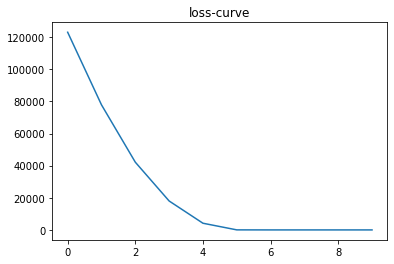

In [14]:
def train(X,Y,X_val,Y_val,U,W,V):
    losses = []
    # train
    for epoch in range(epochs):
        #calc loss
        loss = calc_loss(X,Y,U,V,W)
        losses.append(loss)
        loss_val = calc_loss(X_val,Y_val,U,V,W)
        print(f'Epoch: {epoch} Loss: {loss}, Validation Loss: {loss_val}')
        # loop over each label
        for i in range(Y.shape[0]):
            x,y = X[i],Y[i]
            # forward
            layers,y_hat = forward_pass(x,y,U,V,W)
            # backward
            dU,dV,dW = my_bptt(x,y,U,V,W,layers,y_hat)
            # SGD
            U += learning_rate * dU
            W += learning_rate * dW
            V += learning_rate * dV
    
    return U,W,V,losses

# set hyperparameter
epochs = 10
bptt_truncate = 5
min_clip_val = -10
max_clip_val = 10
            
# init U,W,V
U,W,V = initialize_matrices(T,hidden_dim,output_dim)
# train
U,W,V,losses = train(X,Y,X_val,Y_val,U,W,V)

plt.plot(losses)
plt.title('loss-curve')

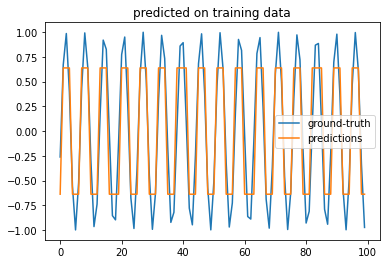

In [15]:
predictions = []
for i in range(Y.shape[0]):
    x,y = X[i],Y[i]
    layers,y_hat = forward_pass(x,y,U,V,W)
    predictions.append(y_hat)

# turn it into numpy array
predictions = np.array(predictions)
plt.plot(Y,label = 'ground-truth')
plt.plot(np.ravel(predictions),label = 'predictions')
plt.legend()
plt.title('predicted on training data')
plt.show()

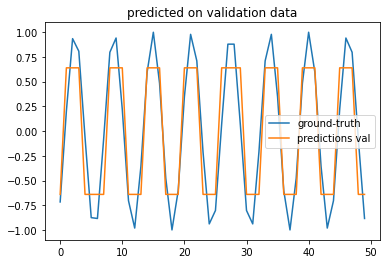

In [16]:
predictions_val = []
for i in range(Y_val.shape[0]):
    x_val,y_val = X_val[i],Y_val[i]
    layers,y_hat = forward_pass(x_val,y_val,U,V,W)
    predictions_val.append(y_hat)

# turn it into numpy array
predictions_val = np.array(predictions_val)
plt.plot(Y_val,label = 'ground-truth')
plt.plot(np.ravel(predictions_val),label = 'predictions val')
plt.legend()
plt.title('predicted on validation data')
plt.show()

#### other sequence wave

200


Text(0.5, 1.0, '')

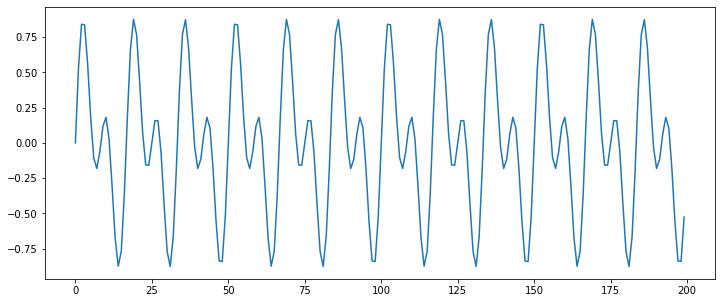

In [17]:
f = 30
seq_wave = np.array([(0.5 * math.sin(1*f*2*np.pi*x) + 0.5 * math.sin(2*f*2*np.pi*x)) for x in np.arange(0,0.4,0.002)])
print(len(seq_wave))
# visualize the seq wave
fig = plt.figure(figsize = (12.,5.))
plt.plot(seq_wave)
plt.title('')

In [18]:
# training dataset
X = []
Y = []
seq_len = 50
num_records = len(seq_wave) - seq_len
print(f'seq_len: {seq_len}')
print(f'num_records: {num_records}')
for i in range(num_records- 50):
    X.append(seq_wave[i:i+seq_len])
    Y.append(seq_wave[i+seq_len])
X = np.array(X)
Y = np.array(Y)
print(f'X.shape before: {X.shape}')
print(f'Y.shape before: {Y.shape}')
X = np.expand_dims(X,axis = 2)
Y = np.expand_dims(Y,axis =1 )
print(f'X.shape after: {X.shape}')
print(f'Y.shape after: {Y.shape}')

seq_len: 50
num_records: 150
X.shape before: (100, 50)
Y.shape before: (100,)
X.shape after: (100, 50, 1)
Y.shape after: (100, 1)


In [19]:
# validation dataset
X_val = []
Y_val = []
seq_len = 50

for i in range(num_records- 50,num_records):
    X_val.append(seq_wave[i:i+seq_len])
    Y_val.append(seq_wave[i+seq_len])
X_val = np.array(X_val)
Y_val = np.array(Y_val)
print(f'X_val.shape before: {X_val.shape}')
print(f'Y_val.shape before: {Y_val.shape}')
X_val = np.expand_dims(X_val,axis = 2)
Y_val = np.expand_dims(Y_val,axis =1 )
print(f'X_val.shape after: {X_val.shape}')
print(f'Y_val.shape after: {Y_val.shape}')

X_val.shape before: (50, 50)
Y_val.shape before: (50,)
X_val.shape after: (50, 50, 1)
Y_val.shape after: (50, 1)


Text(0.5, 1.0, 'full data')

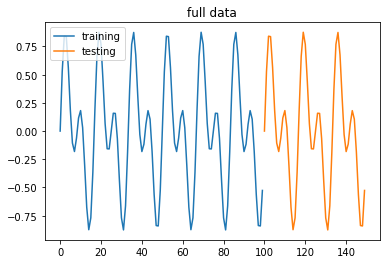

In [20]:
# display full dataset
plt.plot(range(len(X)),Y,label = 'training')
plt.plot(range(len(X),len(X)+len(X_val)),Y_val,label = 'testing')
plt.legend()
plt.title("full data")

In [21]:
# set hyperparameter
epochs = 10
bptt_truncate = 10
min_clip_val = -10
max_clip_val = 10
            
# init U,W,V
U,W,V = initialize_matrices(T,hidden_dim,output_dim)
# train
U,W,V,losses = train(X,Y,X_val,Y_val,U,W,V)

Epoch: 0 Loss: 121889.12628883393, Validation Loss: 60944.563144416956
Epoch: 1 Loss: 77517.64416065326, Validation Loss: 38758.82208032662
Epoch: 2 Loss: 43087.66792999618, Validation Loss: 21543.833964998088
Epoch: 3 Loss: 18625.810523724518, Validation Loss: 9312.905261862257
Epoch: 4 Loss: 4348.102363166344, Validation Loss: 2174.051181583171
Epoch: 5 Loss: 12.999668419952515, Validation Loss: 6.499834209976255
Epoch: 6 Loss: 11.911192934671295, Validation Loss: 5.95559646733566
Epoch: 7 Loss: 12.002087912127813, Validation Loss: 6.001043956063923
Epoch: 8 Loss: 12.005506743462455, Validation Loss: 6.002753371731238
Epoch: 9 Loss: 12.006064015952553, Validation Loss: 6.003032007976296


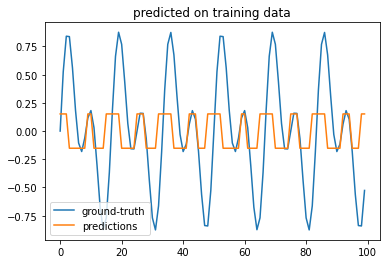

In [22]:
predictions = []
for i in range(Y.shape[0]):
    x,y = X[i],Y[i]
    layers,y_hat = forward_pass(x,y,U,V,W)
    predictions.append(y_hat)

# turn it into numpy array
predictions = np.array(predictions)
plt.plot(Y,label = 'ground-truth')
plt.plot(np.ravel(predictions),label = 'predictions')
plt.legend()
plt.title('predicted on training data')
plt.show()

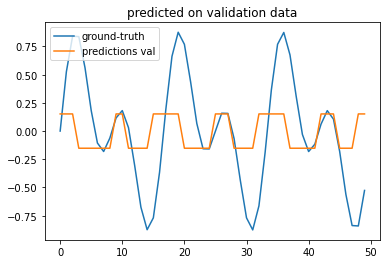

In [23]:
predictions_val = []
for i in range(Y_val.shape[0]):
    x_val,y_val = X_val[i],Y_val[i]
    layers,y_hat = forward_pass(x_val,y_val,U,V,W)
    predictions_val.append(y_hat)

# turn it into numpy array
predictions_val = np.array(predictions_val)
plt.plot(Y_val,label = 'ground-truth')
plt.plot(np.ravel(predictions_val),label = 'predictions val')
plt.legend()
plt.title('predicted on validation data')
plt.show()

####  Huiming Song implementation with bias

As above we assume that $b_{h}$ and $b_{y}$ equal zero,now let count them in gradient descent, We still calculate $\frac{\partial{L_{t}}}{\partial{U}}$ and $\frac{\partial{L_{t}}}{\partial{W}}$ as as above and calculate $b_{h}$ and $b_{y}$ as this follow:

$$\frac{\partial{L_{i}}}{\partial{b_{y}}} = \frac{\partial{L_{i}}}{\partial{\hat{y_{i}}}} \frac{\partial{\hat{y_{i}}}}{\partial{b_{y}}} = y_{i} - \hat{y_{i}}$$

$$\frac{\partial{L}}{\partial{b_{y}}} = \sum_{i}^{m} \frac{\partial{L_{i}}}{\partial{b_{y}}} = \sum_{i}^{m}(y_{i} - \hat{y_{i}})$$

and 

$$\frac{\partial{L_{i}}}{\partial{b_{h}}} = \frac{\partial{L_{i}}}{\partial{\hat{y_{i}}}} \frac{\partial{\hat{y_{i}}}}{\partial{h_{i}}} \frac{\partial{h_{i}}}{\partial{z_{i}}} \frac{\partial{z_{i}}}{\partial{b_{h}}} = (y_{i} - \hat{y_{i}}) V (1 - h_{i}^{2})*1$$

$$\frac{\partial{L}}{\partial{b_{h}}} = \sum_{i}^{m} \frac{\partial{L_{i}}}{\partial{b_{h}}} = \sum_{i}^{m} (y_{i} - \hat{y_{i}}) V (1 - h_{i}^{2})$$






In [48]:
# initialize matrix
def initialize_matrices(T,hidden_dim,output_dim):
    np.random.seed(3454)
    U = np.random.uniform(0,1,(hidden_dim,T)) # weights between input layer and hidden layer
    V = np.random.uniform(0,1,(output_dim,hidden_dim)) # weights between hidden layer and output layer
    W = np.random.uniform(0,1,(hidden_dim,hidden_dim)) # recurrent weights between each timestep layer (RNN weights)
    bh = np.zeros((hidden_dim,1))
    by = np.zeros((output_dim,1))
    return U,W,V,bh,by

U,W,V,bh,by = initialize_matrices(T,hidden_dim,output_dim)

print(f'U {U.shape}')
print(f'V {V.shape}')
print(f'W {W.shape}')
print(f'bh {bh.shape}')
print(f'by {by.shape}')

U (100, 50)
V (1, 100)
W (100, 100)
bh (100, 1)
by (1, 1)


In [49]:
# forward function
x,y = X[0],Y[0]

def forward_pass(x,y,U,V,W,bh,by):
    layers = []
    prev_h = np.zeros((hidden_dim,1))
    for t in range(T):
        new_input = np.zeros(x.shape) # (T,1)
        new_input[t] = x[t]
        z = U @ x + W @ prev_h + bh
        h = tanh(z) # (hidden_dim,T)x(T,1) + (hidden_dim,hidden_dim)x(hidden_dim,1)
        y_hat = o = V @ h + by # (1,hidden_dim)x(hidden_dim,1)
        layers.append({"prev_h":prev_h,"h":h})
        prev_h = h
    return layers,y_hat

layers,y_hat = forward_pass(x,y,U,V,W,bh,by)

In [50]:
# calculate the loss
def calc_loss(X,Y,U,V,W,bh,by):
    loss = 0.0
    for i in range(Y.shape[0]):
        x,y = X[i],Y[i]
        _,y_hat = forward_pass(x,y,U,V,W,bh,by)
        loss += (y - y_hat)**2/2 #mean square error
    return np.float(loss)

loss = calc_loss(X,Y,U,V,W,bh,by)
loss_val = calc_loss(X,Y,U,V,W,bh,by)
print(f'Loss: {loss}, Validation Loss: {loss_val}')

Loss: 123018.72740117362, Validation Loss: 123018.72740117362


In [27]:
def my_bptt(x,y,U,V,W,bh,by,layers,y_hat):
    
    # differentials at current prediction
    dU = np.zeros(U.shape)
    dW = np.zeros(W.shape)
    dV = np.zeros(V.shape)
    
    d_bh = np.zeros(bh.shape)
    d_by = np.zeros(by.shape)
    
    # differentials each timestep
    dU_t = np.zeros(U.shape)
    dW_t = np.zeros(W.shape)
    dV_t = np.zeros(V.shape)
    
    # differentials each backpropagation truncate
    dU_i = np.zeros(U.shape)
    dW_i = np.zeros(W.shape)
    
    #dL/dy
    dmulv = y - y_hat # (1,1)
    
    #dL/dh = dL/dy * dy/dh
    dsv = V.T @ dmulv # (100,1)
    
    # calc d_by
    d_by = dmulv

    def calc_prev_d(h,d,W):
        d_sum = (1-h**2)*d # activation_function *  
        return W.T @ d_sum # W.T or W ??
    
    for t in range(T):
        
        #print(f'timestep: {t}')
        # differential dLdV each timestep
        dV_t = dmulv @ np.transpose(layers[t]['h']) # (1,1)x(100,1).T
        
        # term d = (y-y_hat)V
        d_t = dsv * (1 - layers[t]['h']**2) # V.T.(y - y_hat)(1-h^2) (100,1)
        
        # calc d_bh
        d_bh += d_t # dsv * (1 - layers[t]['h']**2)
        
        for _ in range(t,max(-1,t-bptt_truncate-1),-1):
            
            new_input  = np.zeros(x.shape)
            new_input[_] = x[_]
            
            dU_i = d_t @ new_input.T
            dW_i = d_t @ layers[_]['prev_h'].T
            
            dU_t += dU_i
            dW_t += dW_i
            
            d_t = calc_prev_d(layers[_]['prev_h'],d_t,W)
            #print(f'\tstep: {_}')
                
        # accumulate differentials each timestep
        dV += dV_t
        dU += dU_t
        dW += dW_t
        
        # take care of possible exploding gradients
        if dU.max() > max_clip_val:
            dU[dU > max_clip_val] = max_clip_val
        if dV.max() > max_clip_val:
            dV[dV > max_clip_val] = max_clip_val
        if dW.max() > max_clip_val:
            dW[dW > max_clip_val] = max_clip_val
        if d_bh.max() > max_clip_val:
            d_bh[d_bh > max_clip_val] = max_clip_val
        if d_by.max() > max_clip_val:
            d_by[d_by > max_clip_val] = max_clip_val
        
        if dU.min() < min_clip_val:
            dU[dU < min_clip_val] = min_clip_val
        if dV.min() < min_clip_val:
            dV[dV < min_clip_val] = min_clip_val
        if dW.min() < min_clip_val:
            dW[dW < min_clip_val] = min_clip_val
        if d_bh.max() > max_clip_val:
            d_bh[d_bh > max_clip_val] = max_clip_val
        if d_by.max() > max_clip_val:
            d_by[d_by > max_clip_val] = max_clip_val
    
    return dU,dV,dW,d_bh,d_by

bptt_truncate = 3

x,y = X[0],Y[0]

layers,y_hat = forward_pass(x,y,U,V,W,bh,by)

dU,dV,dW,d_bh,d_by = my_bptt(x,y,U,V,W,bh,by,layers,y_hat)

Epoch: 0 Loss: 123018.72740117362, Validation Loss: 61470.18100935633
Epoch: 1 Loss: 59549.662668907265, Validation Loss: 29735.085561466945
Epoch: 2 Loss: 18104.17873442273, Validation Loss: 8987.340454321817
Epoch: 3 Loss: 688.9124215331609, Validation Loss: 341.50825324185405
Epoch: 4 Loss: 5.2926351869285035, Validation Loss: 2.9556667900740643
Epoch: 5 Loss: 5.134190245732753, Validation Loss: 2.7358221672017526
Epoch: 6 Loss: 5.425425123115913, Validation Loss: 2.917698829671405
Epoch: 7 Loss: 5.415942162008483, Validation Loss: 2.913823580974387
Epoch: 8 Loss: 5.406684470146924, Validation Loss: 2.9100534629541617
Epoch: 9 Loss: 6.419645329145139, Validation Loss: 3.911671685087013


Text(0.5, 1.0, 'loss-curve')

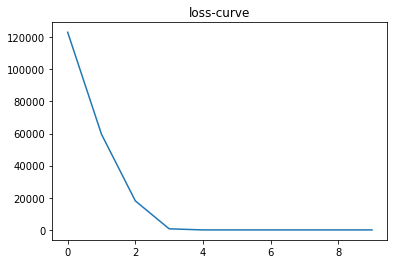

In [51]:
def train(X,Y,X_val,Y_val,U,W,V,bh,by):
    losses = []
    # train
    for epoch in range(epochs):
        #calc loss
        loss = calc_loss(X,Y,U,V,W,bh,by)
        losses.append(loss)
        loss_val = calc_loss(X_val,Y_val,U,V,W,bh,by)
        print(f'Epoch: {epoch} Loss: {loss}, Validation Loss: {loss_val}')
        # loop over each label
        for i in range(Y.shape[0]):
            x,y = X[i],Y[i]
            # forward
            layers,y_hat = forward_pass(x,y,U,V,W,bh,by)
            # backward
            dU,dV,dW,d_bh,d_by = my_bptt(x,y,U,V,W,bh,by,layers,y_hat)
            # SGD
            U += learning_rate * dU
            W += learning_rate * dW
            V += learning_rate * dV
            bh += learning_rate * d_bh
            by += learning_rate * d_by
    
    return U,W,V,losses

# set hyperparameter
epochs = 10
bptt_truncate = 5
min_clip_val = -15
max_clip_val = 15
            
# init U,W,V
U,W,V,bh,by = initialize_matrices(T,hidden_dim,output_dim)
# train
U,W,V,losses = train(X,Y,X_val,Y_val,U,W,V,bh,by)

plt.plot(losses)
plt.title('loss-curve')

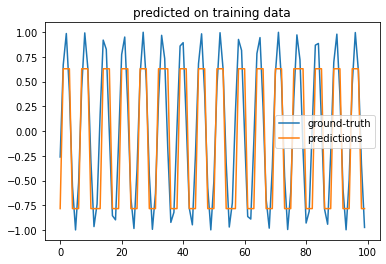

In [52]:
predictions = []
for i in range(Y.shape[0]):
    x,y = X[i],Y[i]
    layers,y_hat = forward_pass(x,y,U,V,W,bh,by)
    predictions.append(y_hat)

# turn it into numpy array
predictions = np.array(predictions)
plt.plot(Y,label = 'ground-truth')
plt.plot(np.ravel(predictions),label = 'predictions')
plt.legend()
plt.title('predicted on training data')
plt.show()

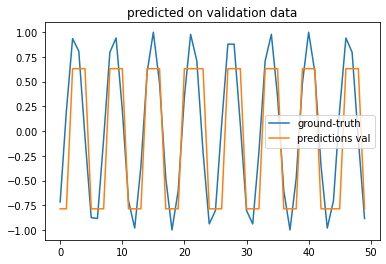

In [53]:
predictions_val = []
for i in range(Y_val.shape[0]):
    x,y = X_val[i],Y_val[i]
    layers,y_hat = forward_pass(x,y,U,V,W,bh,by)
    predictions_val.append(y_hat)

# turn it into numpy array
predictions_val = np.array(predictions_val)
plt.plot(Y_val,label = 'ground-truth')
plt.plot(np.ravel(predictions_val),label = 'predictions val')
plt.legend()
plt.title('predicted on validation data')
plt.show()

### RNN - keras

Use keras to train `MNIST`

The sequential model hase
- input_layer: `SimpleRNN` with `64 nodes` and input_shape is `(None,28)` because that is the input_shape of `MNIST` dataset
- batch_norm layer: `BatchNormalization` this layer normalizes its inputs
- fully-connected layer: `Dense`

In [100]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [83]:
# create sequential model
model = keras.Sequential()
# add layers
model.add(layers.SimpleRNN(64,input_shape = (None,28))) # 64x(64+28+1)
model.add(layers.BatchNormalization()) # 64x4
model.add(layers.Dense(10)) # 10x(64+1)
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 64)                5952      
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 6,858
Trainable params: 6,730
Non-trainable params: 128
_________________________________________________________________
None


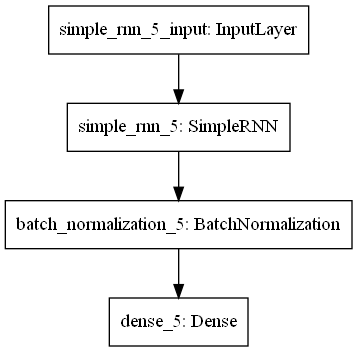

In [84]:
plot_model(model)

x_train: (60000, 28, 28)
x_test: (10000, 28, 28)
y_train: (60000,)
y_test: (10000,)
sample: (28, 28)
sample_label: 7


Text(0.5, 1.0, '5')

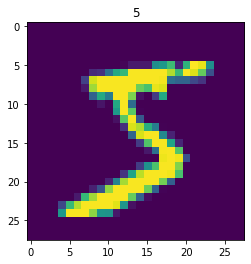

In [85]:
mnist = keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()
# normalize
x_train,x_test = x_train/255.0,x_test/255.0
sample,sample_label = x_test[0],y_test[0]
print(f'x_train: {x_train.shape}')
print(f'x_test: {x_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')
print(f'sample: {sample.shape}')
print(f'sample_label: {sample_label}')
plt.imshow(x_train[0])
plt.title(y_train[0])

In [86]:
# if you don't change the label to one-hot you have to use sparse_categorical_entropy
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             optimizer = 'sgd',
             metrics = ['accuracy']
             )

In [87]:
history = model.fit(x_train,y_train,
         validation_data = (x_test,y_test),
         batch_size = 64,
         epochs = 5,
         verbose = True
         )

Epoch 1/5
938/938 [==============================] - 10s 10ms/step - loss: 0.6768 - accuracy: 0.7993 - val_loss: 0.3946 - val_accuracy: 0.8801
Epoch 2/5
938/938 [==============================] - 10s 10ms/step - loss: 0.3414 - accuracy: 0.8997 - val_loss: 0.3206 - val_accuracy: 0.9022
Epoch 3/5
938/938 [==============================] - 9s 10ms/step - loss: 0.2597 - accuracy: 0.9239 - val_loss: 0.2360 - val_accuracy: 0.9290
Epoch 4/5
938/938 [==============================] - 10s 11ms/step - loss: 0.2221 - accuracy: 0.9347 - val_loss: 0.1811 - val_accuracy: 0.9443
Epoch 5/5
938/938 [==============================] - 10s 11ms/step - loss: 0.1972 - accuracy: 0.9420 - val_loss: 0.1990 - val_accuracy: 0.9380


<AxesSubplot:>

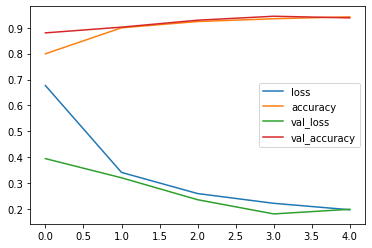

In [90]:
pd.DataFrame(history.history).plot()

In [95]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.1990 - accuracy: 0.9380


[0.19898438453674316, 0.9380000233650208]

In [106]:
result = tf.argmax(model.predict(tf.expand_dims(sample,0)),axis =1)
print(result.numpy(),sample_label)

[7] 7


7

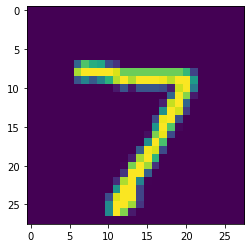

In [103]:
plt.imshow(x_test[0])
np.argmax(model.predict(np.expand_dims(x_test[0],0)))

### references

https://github.com/ytang07/nn_examples/blob/main/rnn/simple_rnn.py

https://songhuiming.github.io/pages/2017/08/20/build-recurrent-neural-network-from-scratch/

https://github.com/vzhou842/rnn-from-scratch

https://pythonalgos.com/build-a-simple-recurrent-neural-network-with-keras/